# Competition Description 

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Goal

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

## Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

Basic imports

In [287]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Load dfs

In [288]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [289]:
#Save ID column
train_ID = train_df['Id']
test_ID = test_df['Id']

### Basic df exploration

In [290]:
train_df.shape

(1460, 81)

We can already see there is a important number of columns, 81 in total.

In [291]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [292]:
# ID looks redundant for training, so we will just drop it
train_df.drop('Id', axis=1, inplace=True) # Axis 1 is for columns, 0 for rows

test_df.drop('Id', axis=1, inplace=True)

In [293]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [294]:
# Our target column to predict willl be SalePrice
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\javie\AppData\Local\Temp\ipykernel_21136\1026489844.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


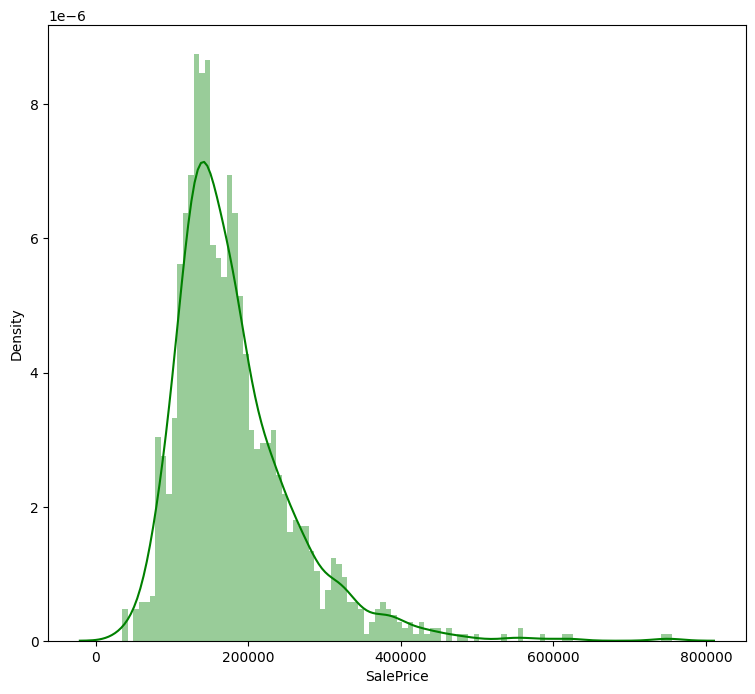

In [295]:
# Lets plot SalePrice histogram
plt.figure(figsize=(9, 8))

# Histogram
# sns.histplot(alt_df, x='SalePrice', bins=100, binwidth=1, kde=True) This function takes ages
# so we will be using a deprecated version

sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

The histogram shows some sort of gaussian distribution, where most of the prices hover around 180.000 $

### Exploratory Data Analysis

As there are 79 feature columns, lets separate them according to its data type

In [296]:
list(set(train_df.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

In [297]:
# sub-df for the numerical columns
numerical_df = train_df.copy().select_dtypes(include = ['float64', 'int64'])

# sub.df for categorical columns
categorical_df = train_df.copy().select_dtypes(include = ['O']) # object

In [298]:
print(numerical_df.shape)
numerical_df.head(2)

(1460, 37)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500


In [299]:
print(categorical_df.shape)
categorical_df.head(2)

(1460, 43)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


Lets see all numerical columns distribution

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

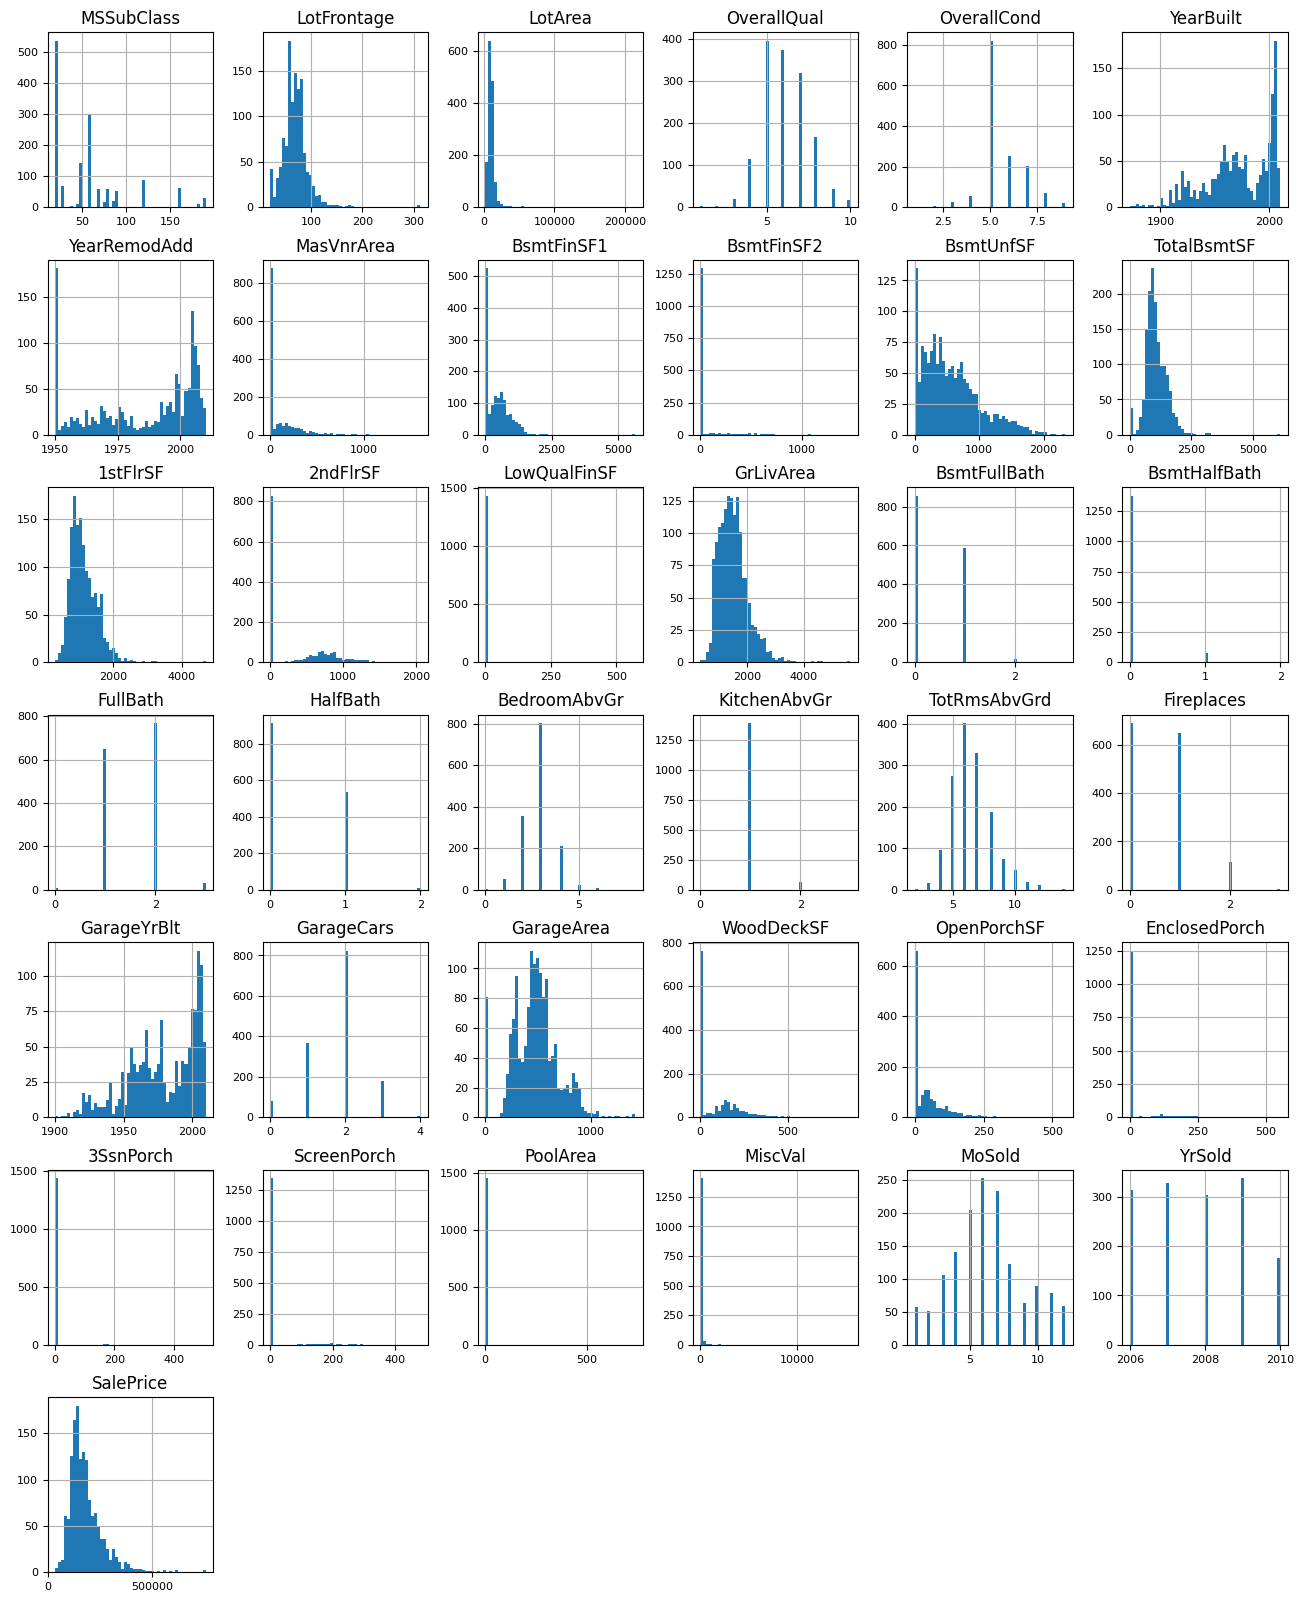

In [300]:
numerical_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

- There are some numerical features with discrete distribution, might be categorical

- Some columns appear to not be very informative: BsmtFinSF2, LowQualFinSF, BsmtHalfBath, KitchenAbvGr, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea and MiscVal.

- Some features seem to have large outlyers, maybe log_transform is a good idea.

Now lets take a step back and think about which features will influence the most the Sales Price.
What comes to my mind is the quality of the materials, if the house is new, the dimensions of the house or if the area is expensive.

Some of the features related to our topics could be:

- OverallQual: Rates the overall material and finish of the house
- YearBuilt: Original construction date
- TotalBsmtSF: Total square feet of basement area
- GrLivArea: Above grade (ground) living area square feet
- MSZoning: Identifies the general zoning classification of the sale.

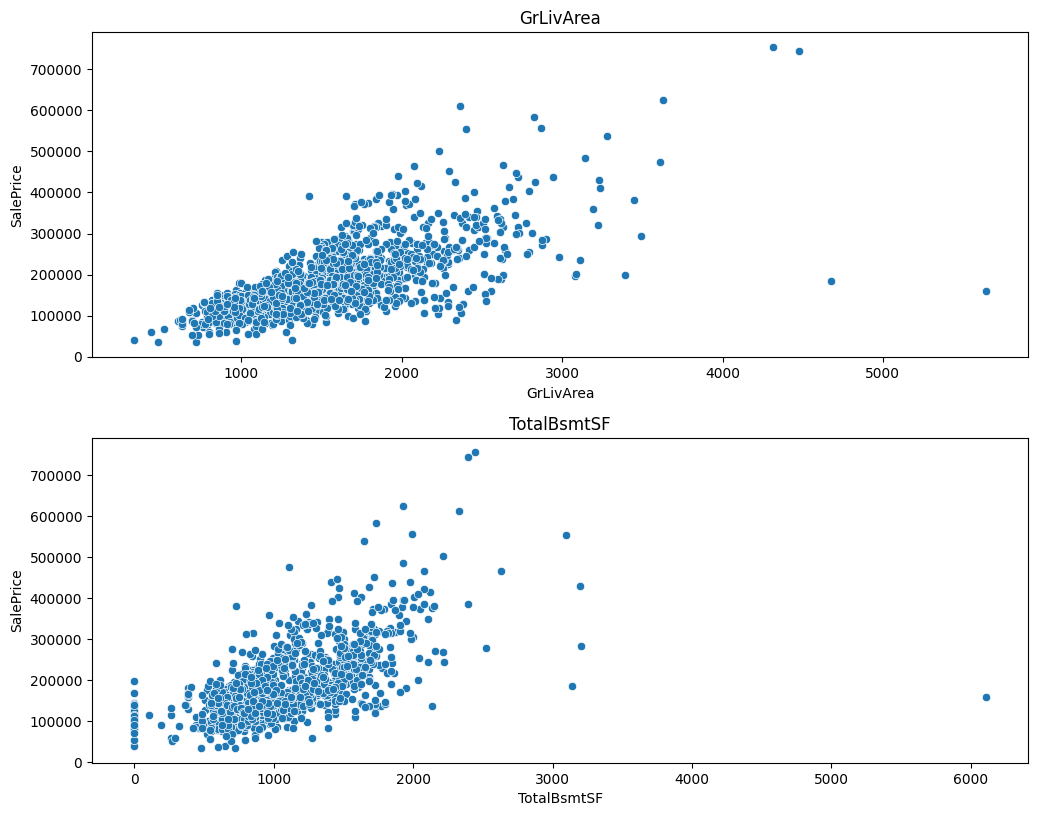

In [301]:
# Lets scatter plot the numerical features looking for relationships

# Numerical features
num_feats=['GrLivArea', 'TotalBsmtSF']

# Plot Numerical features
fig=plt.figure(figsize=(20,20))
for i, var_name in enumerate(num_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.scatterplot(data=train_df, x=var_name, y="SalePrice")
    ax.set_title(var_name)
    
fig.tight_layout()  # Improves appearance a bit
plt.show()

It seems both features have linear relationship with sale price and a few outliers

In [302]:
# Deleting outliers
train = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

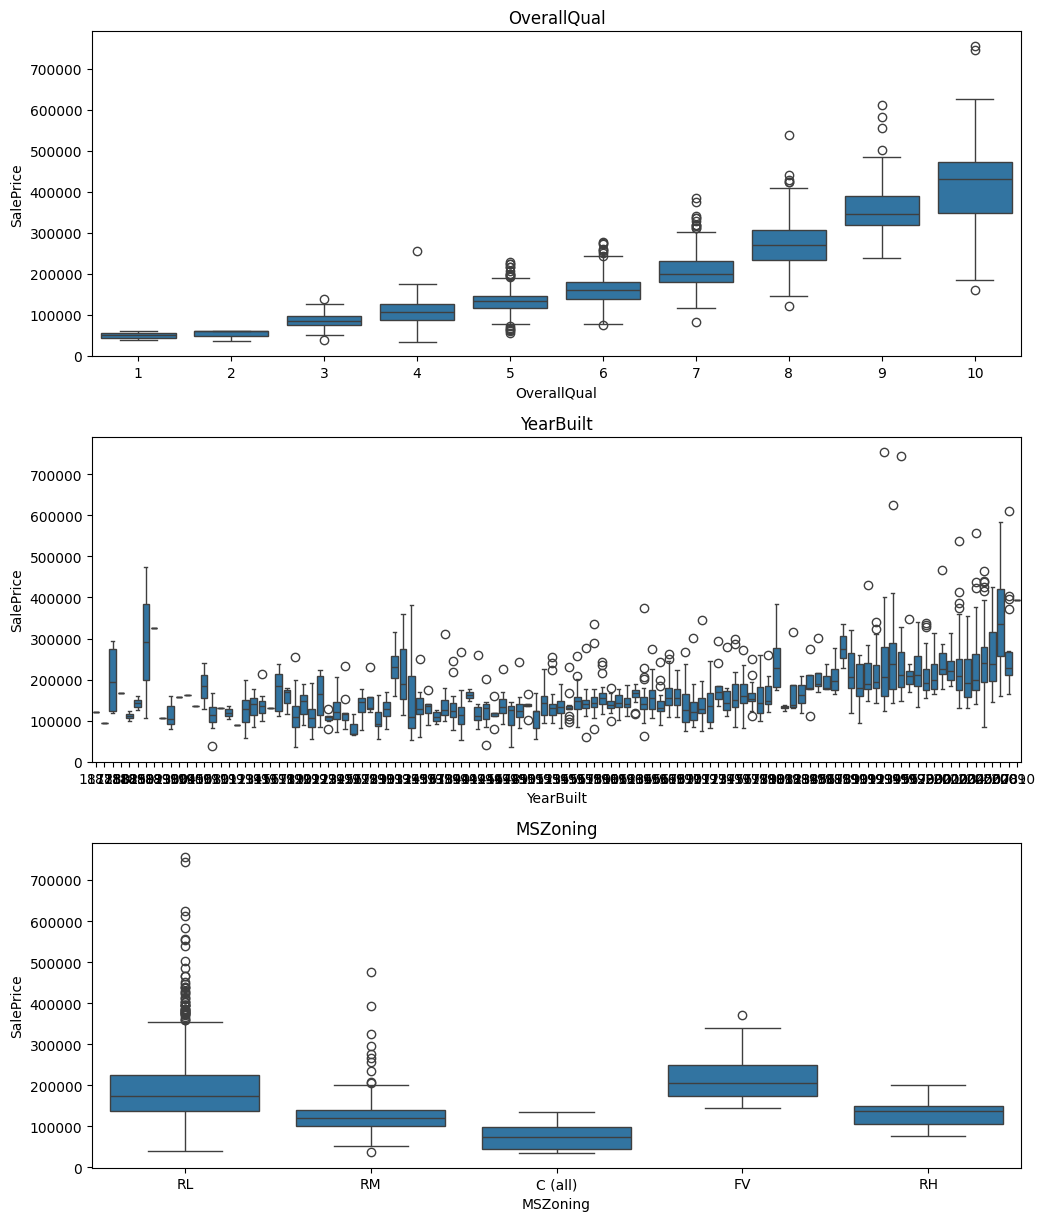

In [303]:
# Categorical features
cat_feats=['OverallQual', 'YearBuilt', 'MSZoning']

# Plot Numerical features
fig=plt.figure(figsize=(20,20))
for i, var_name in enumerate(cat_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.boxplot(data=train_df, x=var_name, y="SalePrice")
    ax.set_title(var_name)
    
fig.tight_layout()  # Improves appearance a bit
plt.show()

- OverallQual: for higher quality we clearly see the price increases
- YearBuilt: seems that newer houses tend to be more expensive
- MSZoning: Residential and low density areas seem to be more expensive.

We just analysed four variables, but there are many other that we should analyse. The trick here seems to be the choice of the right features (feature selection) and not the definition of complex relationships between them (feature engineering).

Our next step will be to analyse feature correlations, so we wil start with a correlation matrix. 
- A correlation matrix is a table showing correlation coefficients between pairs of variables. 
- Correlation measures the strength and direction of a linear relationship between two variables. Rangin between -1 and 1.
- A correlation matrix will help us identify strong relationships, feature selection (removing redundant information) and to detect multicollinearity  (high correlation between independent variables).

<Axes: >

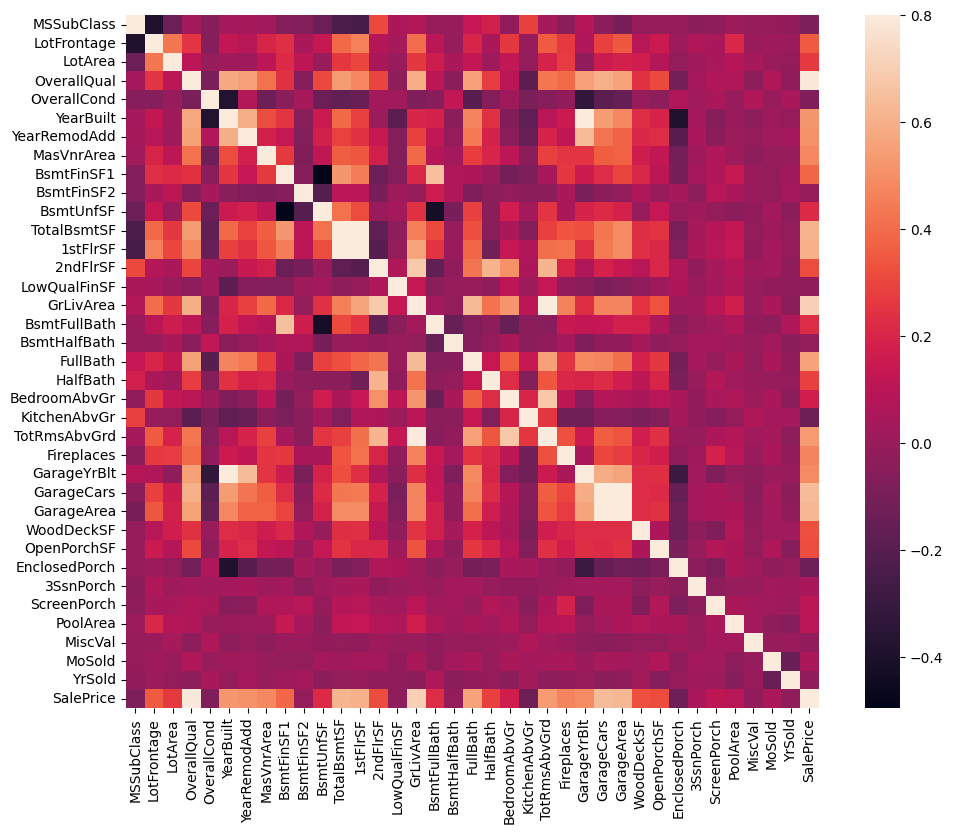

In [304]:
# Correlation Matrix for the numerical features
corrmat = numerical_df.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

At first sigut we can see a high correlation between 'TotalBsmtSF' and '1stFlrSF'and between all the Garage features.
Actually, this correlation is so strong that it may indicate a situation of multicollinearity. Multicollinearity occurs when two or more independent variables in a dataset are highly correlated, meaning they provide almost the same information. In practical terms, these variables are not adding unique value to the model, and their presence together can cause problems in certain types of analysis, particularly in regression models.

Additionally, the features we manually selected, in fact seem to be highly correlated.

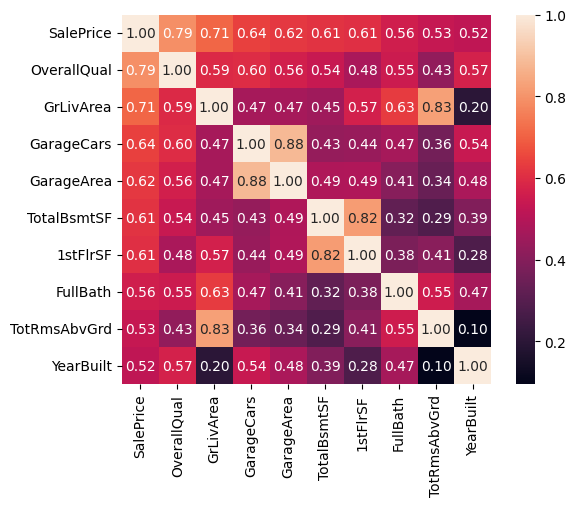

In [305]:
# Lets see the k fatures more correlated to SalePrice

# Find the 'k' most correlated columns with 'SalePrice'
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index # indexes of the most correlated columns

# Compute the correlation matrix for the selected columns
# 'numerical_df[cols].values.T' returns the transposed matrix of the selected variables' values
# 'np.corrcoef' computes the pairwise correlation coefficients for the selected variables
cm = np.corrcoef(numerical_df[cols].values.T)

# Generate a heatmap of the correlation matrix
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- **OverallQual**, **GrLivArea**, and **TotalBsmtS** exhibit strong correlations with **SalePrice**, making them key variables in predicting the target.
- Both **GarageCars** and **GarageArea** are also highly correlated with **SalePrice**. However, as noted earlier, the number of cars a garage can accommodate is directly dependent on the size of the garage. These two variables essentially convey the same information and are highly redundant. Therefore, only one of them should be retained in the analysis. Given that **GarageCars** has a slightly stronger correlation with **SalePrice**, we will prioritize it over **GarageArea**.
- Similarly, **TotalBsmtSF** and **1stFlrSF** show a strong relationship, indicating redundancy. We will retain **TotalBsmtSF** to align with our initial hypothesis.
- The variables **TotRmsAbvGrd** and **GrLivArea** are highly correlated as well, displaying a similar redundancy. 
- Lastly, **YearBuilt** shows a moderate correlation with **SalePrice**, indicating that the age of the property may have some influence on its value.


c:\Users\javie\Programacion\GitHub\HOUSEPRICES-KAGGLE\.venv\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


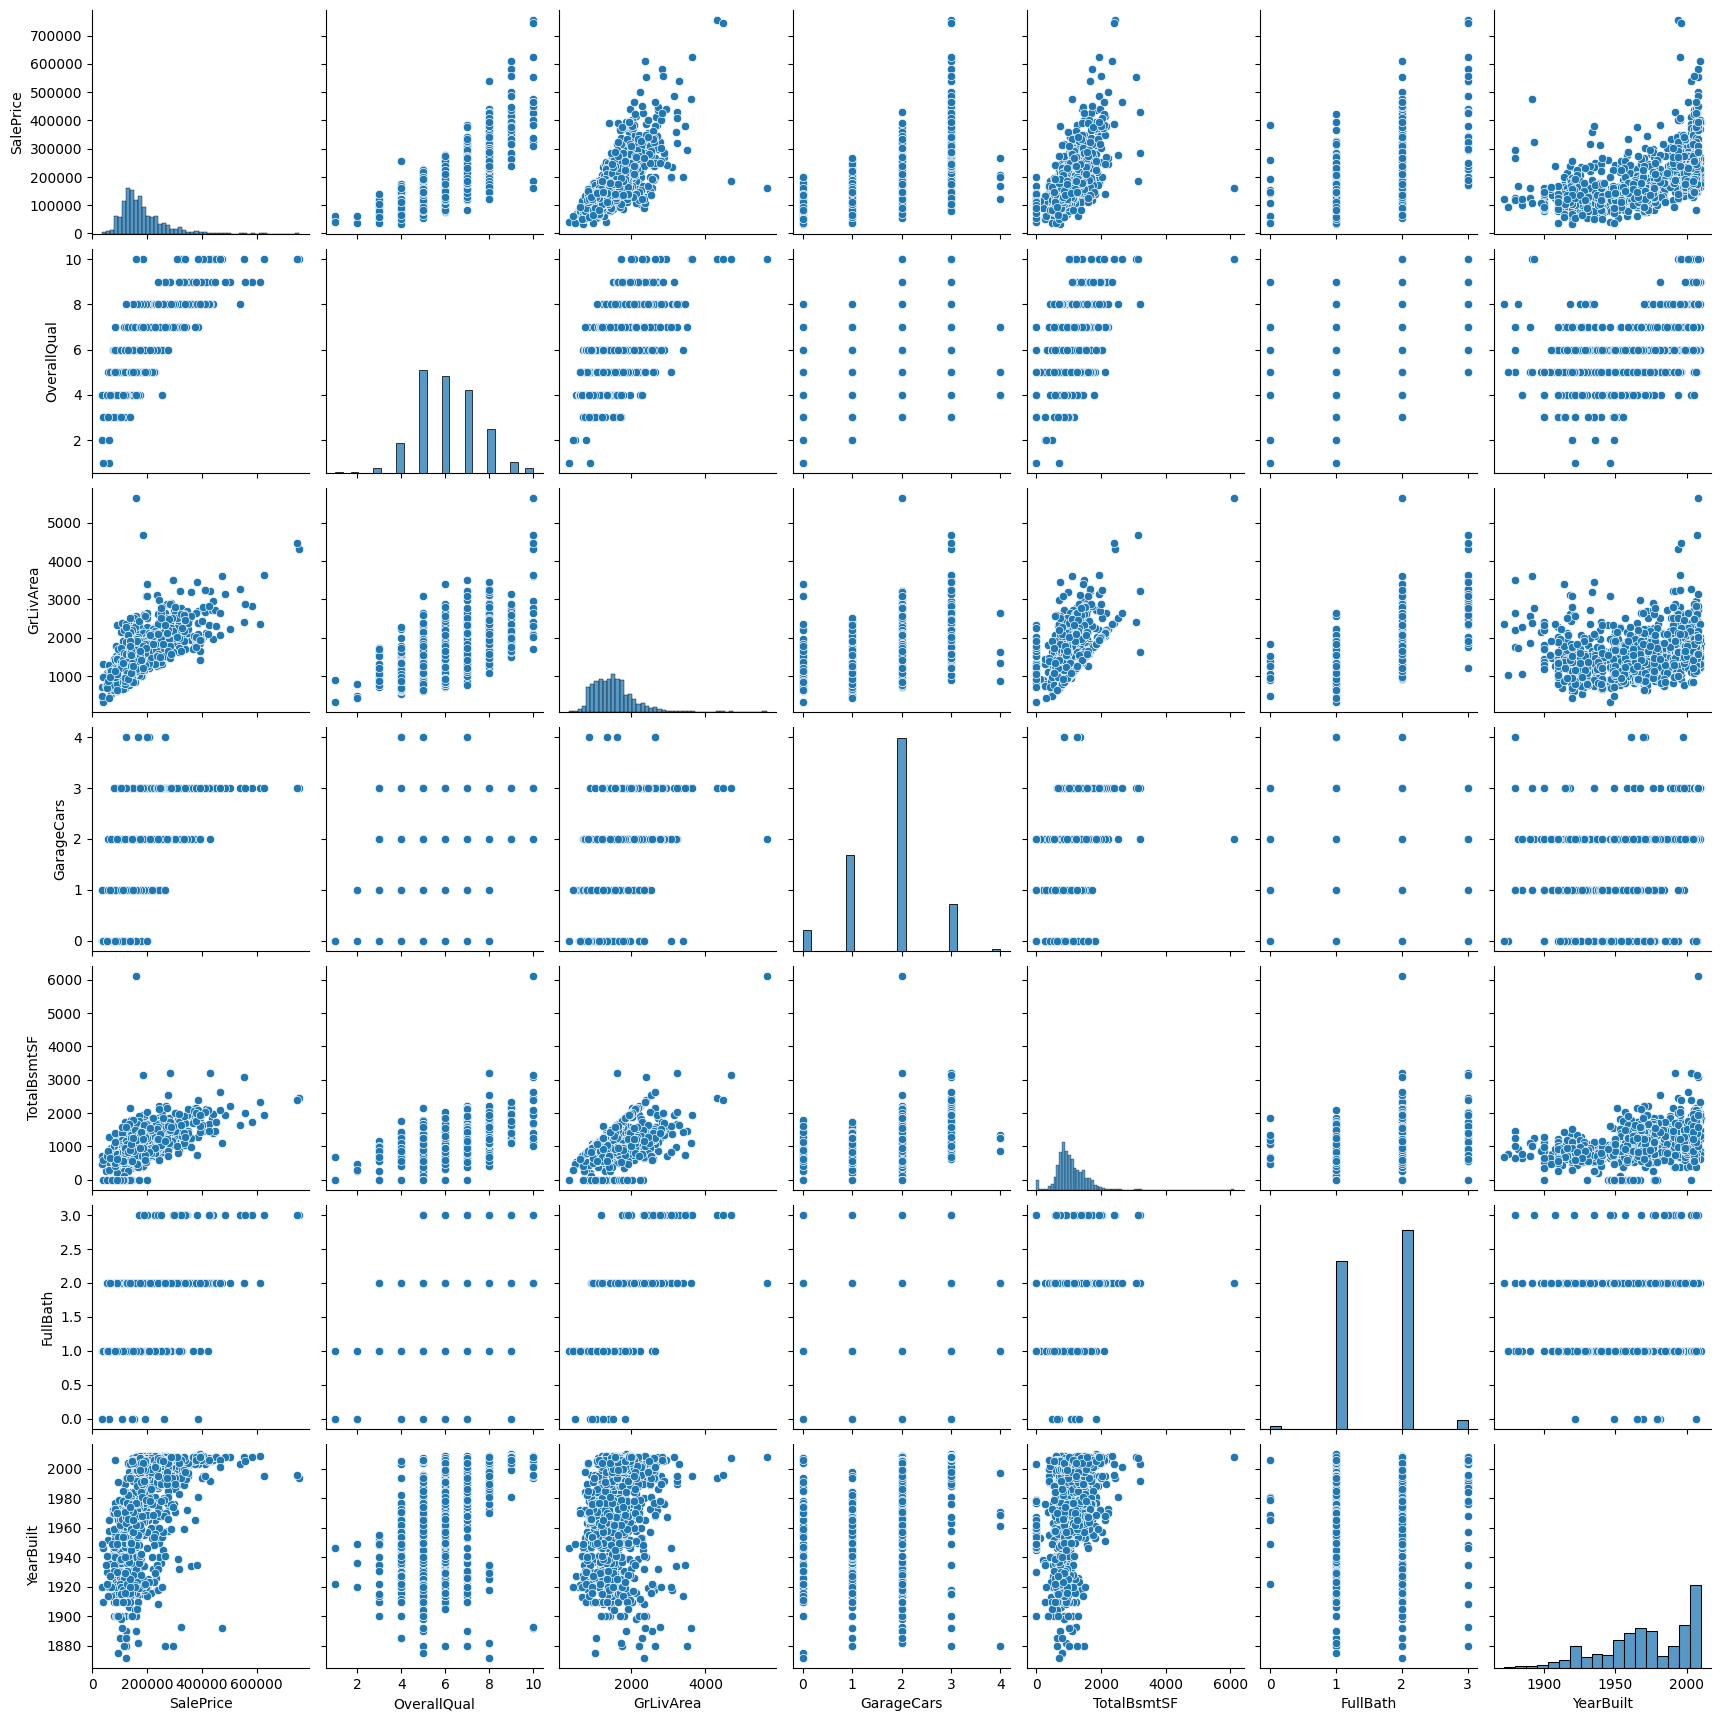

In [306]:
# Lets scatter plot the most correlated features
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(numerical_df[cols], size = 2.5)
plt.show()

A particularly interesting relationship is the one between **TotalBsmtSF** (total basement square footage) and **GrLivArea** (above-ground living area). In the scatter plot, we notice that the points tend to form a clear linear boundary, with most of them sitting below this line.

This makes sense because, for most homes, the basement area is usually equal to or smaller than the above-ground living space. While it’s possible for the basement to be as large as the living area, it's quite rare to see a basement that's bigger.

### Missing Data

In this part of the code, we will be handling with missing values in de dataset

In [307]:
# Concat df to get all missing data
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)

ntrain = train_df.shape[0]
ntest = test_df.shape[0]
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [308]:
# Columns with missing values
na_cols=all_data.columns[all_data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(all_data[na_cols].isna().sum().sort_values(ascending=False), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(all_data),2)
mv

,Number_missing,Percentage_missing
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
MasVnrType,1766,60.50
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageFinish,159,5.45
GarageQual,159,5.45
GarageCond,159,5.45


Text(0.5, 1.0, 'Heatmap of missing values')

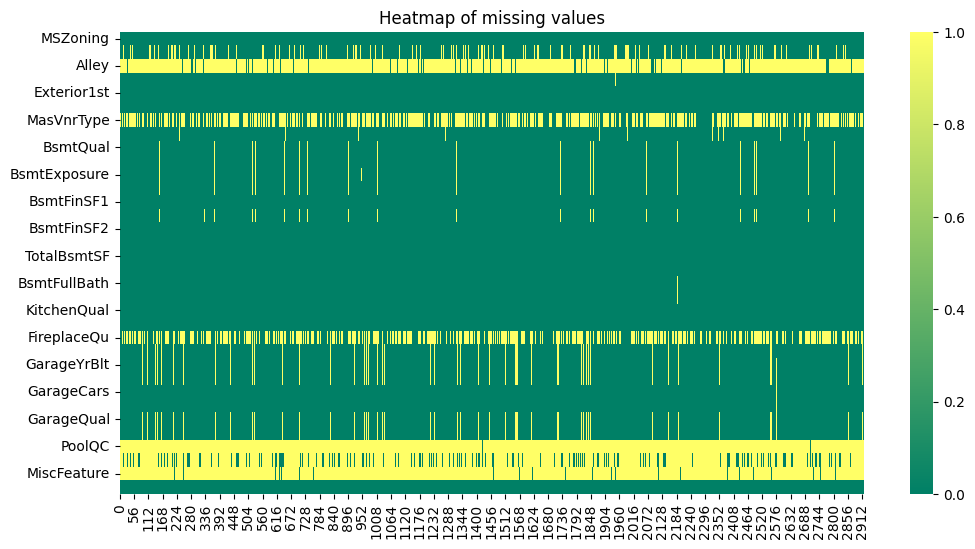

In [309]:
# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(all_data[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

- The first noticeable thing is that some features have a high percentage of missing data, meaning that maybe they are not useful features for our model. In this case, **PoolQC**, **MiscFeature**, **Alley** and **Fence** are missing more than 80% of data. These variables do not appear to be critical factors when purchasing a home, as buyers generally don't prioritize these aspects in their decision-making process. Moreover, looking closer at the variables, we could say that these features are strong candidates for outliers. Therefore, we might consider removing them from our analysis.

- Another interesting observation is that all garage-related features are missing the exact same data points, as shown in the heatmap. This consistency suggests that these features may be derived from the same set of observations, or that if a garage is absent, all related data is also missing.  Additionally, the most informative feature is **GarageCars**, so we might consider dropping the other garage-related variables to reduce redundancy without losing much information.

- Lastly, there is a single missing value in the **Electrical** variable. Since it's only one observation, we can safely remove this record without significantly impacting the dataset, while retaining the **Electrical** variable for further analysis.

In [310]:
# Drop unninformative columns
all_data.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "GarageCond", "GarageType", "GarageYrBlt", "GarageFinish", "GarageQual"], axis=1, inplace=True)

In [311]:
all_data["MasVnrType"].value_counts()

MasVnrType
BrkFace    879
Stone      249
BrkCmn      25
Name: count, dtype: int64

- As **MasVnrTypeLets** doesn't seem to provide useful information, lets remove it aswell.

In [312]:
all_data.drop("MasVnrType", axis=1, inplace=True)

In [313]:
all_data["FireplaceQu"].value_counts()

FireplaceQu
Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: count, dtype: int64

- **FireplaceQu** missing values could mean that the house has no fireplace, so maybe a good approach is to change this feature for a categorical one, where 0 equals no fireplace and 1 means ther is a fireplace.

In [314]:
# Categorical column indicating if there is a fireplace or not
all_data["HasFireplace"] = all_data['FireplaceQu'].apply(lambda x: 0 if pd.isna(x) else 1)

# Drop FireplaceQu
all_data.drop("FireplaceQu", axis=1, inplace=True)

Lets see if we can replace missing from LotFrontage 

<Axes: >

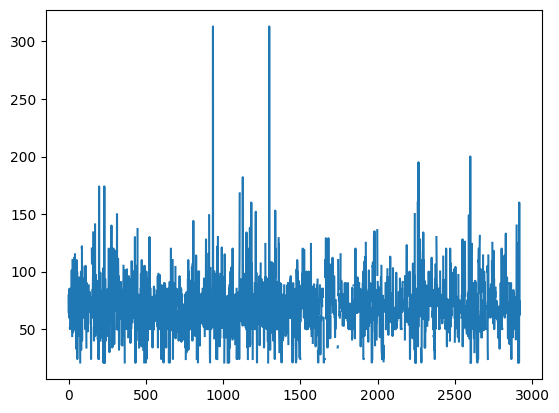

In [315]:
# Plot LotFrontage
all_data["LotFrontage"].plot()

The data in the graph appears to be relatively noisy with some clear outliers (large spikes), and it represents the number of meters of road before a home. Before deciding how to fill the missing data, let's consider a few important points:
- Filling missing values with the mean and then adding some random noise based on the standard deviation could work if the data follows a roughly normal (Gaussian) distribution. However, this approach is typically used when the data is symmetric and lacks significant outliers. Looking at the graph, there are some large spikes that suggest the data might not follow a normal distribution.
- The spikes in the plot indicate potential outliers, and filling the missing values with the mean might introduce bias if those outliers represent true observations. The mean is sensitive to outliers, so if data is skewed, filling missing values with the mean might not be the best choice.
- Since there are clear outliers, the median could be a better choice than the mean. The median is less affected by outliers and would give a more robust central tendency of the data.

In [316]:
# Missing values before
LF_bef=all_data['LotFrontage'].isna().sum()

# Fill NaN values in the 'RoadMetersBeforeHome' column with the median
all_data['LotFrontage'].fillna(all_data['LotFrontage'].median(), inplace=True)

# Print number of missing values left
print('#LotFrontage missing values before:',LF_bef)
print('#LotFrontage missing values after:',all_data['LotFrontage'].isna().sum())

#LotFrontage missing values before: 486
#LotFrontage missing values after: 0


- For the basement features, we will asume theyr absence means that the house has no basement, so we will fill the values with a string None.

In [317]:
# Basement features
bsmnt_feat = ["BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]

# Missing values before
BS_bef=all_data[bsmnt_feat].isna().sum()

# Replace NaNs with 'None' in the selected columns
all_data[bsmnt_feat] = all_data[bsmnt_feat].map(lambda x: 'None' if pd.isna(x) else x)

# Print number of missing values left
print('#Bsmnt missing values before:',BS_bef)
print('#Bsmnt missing values after:',all_data[bsmnt_feat].isna().sum())

#Bsmnt missing values before: BsmtCond        82
BsmtExposure    82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
dtype: int64
#Bsmnt missing values after: BsmtCond        0
BsmtExposure    0
BsmtQual        0
BsmtFinType2    0
BsmtFinType1    0
dtype: int64


- **MSZoning** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'
- **MasVnrArea** : NA most likely means no masonry veneer for these houses. We can fill with 0.

In [318]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [319]:
# Columns still with missing values
na_cols = all_data.columns[all_data.isna().any()].tolist()

# Missing values summary
mv = pd.DataFrame(all_data[na_cols].isna().sum().sort_values(ascending=False), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(all_data),2)
mv

,Number_missing,Percentage_missing
Utilities,2,0.07
BsmtFullBath,2,0.07
BsmtHalfBath,2,0.07
Functional,2,0.07
Exterior1st,1,0.03
Exterior2nd,1,0.03
BsmtFinSF1,1,0.03
BsmtFinSF2,1,0.03
BsmtUnfSF,1,0.03
TotalBsmtSF,1,0.03


For the rest of the features, as they are not missing much data and doesn't seem very important, we will just replace by the mode

In [320]:
# Columns still with missing values
na_cols = all_data.columns[all_data.isna().any()].tolist()

# Replace with the mode
for col in na_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Checking if there are any remaining missing values
all_data.isnull().sum().max() # If 0, no missing values remain

0

### Log Transform

**Log Transformation** is a non-linear transformation that compresses the range the your data by applying a logarithmic function. It is often used to reduce skewness and stabilize the variance of your data.

- It is a good idea to use it when data is **right-skewed** (i.e., has a long tail of large values), log transformation can help make the distribution more normal, or when we want to reduce the impact of **outliers** as log transformation compresses large values more than small ones.

In our case, are there are many features, we will be aplying log transformation to the most correlated ones, in order to deal with skew and outliers.


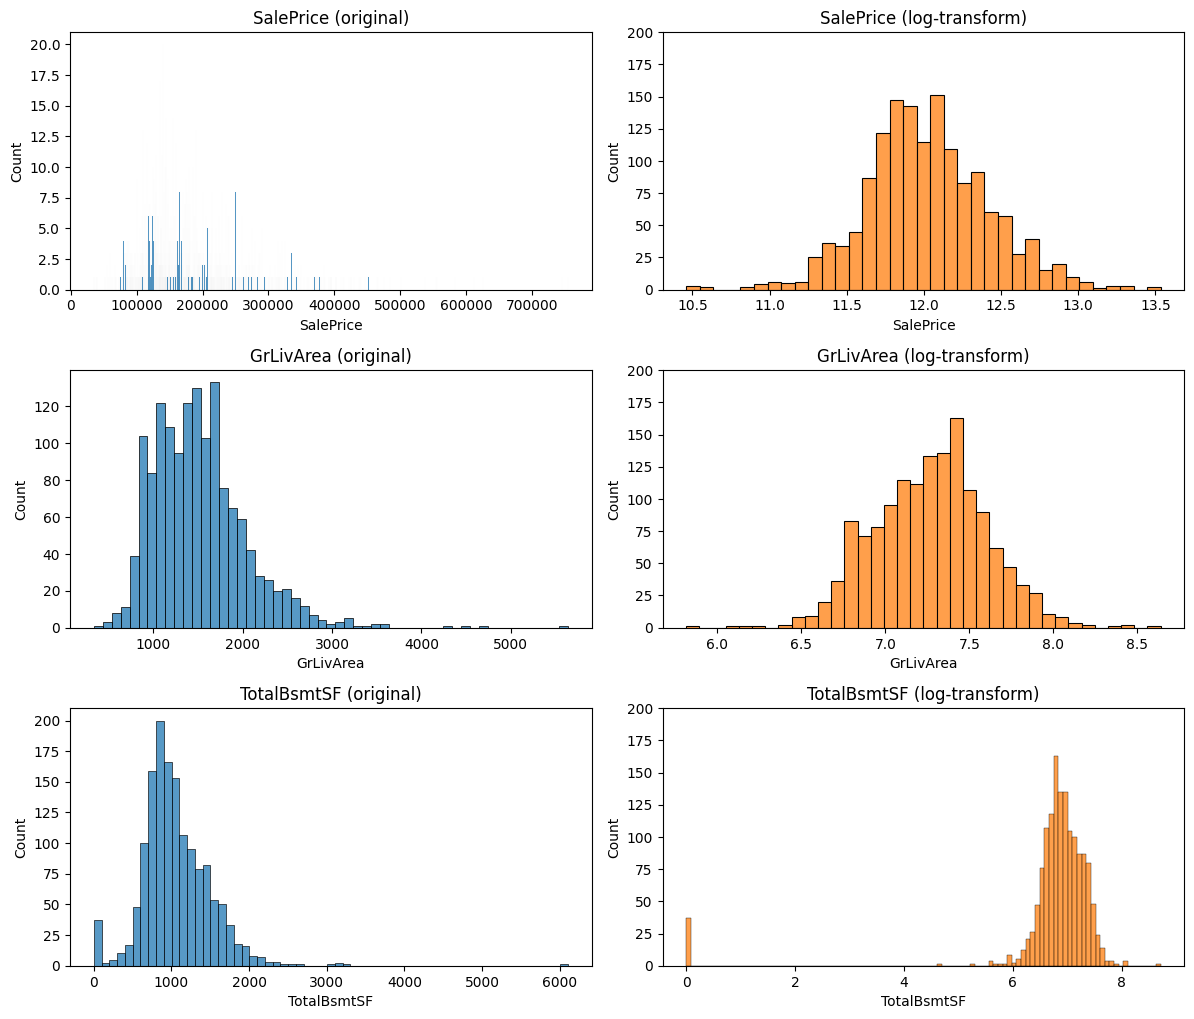

In [321]:
# Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['SalePrice','GrLivArea','TotalBsmtSF']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(train_df[col], binwidth=100)
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+train_df[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

In [322]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 252)


In [323]:
train_df['SalePrice'].mean()

180921.19589041095

In [324]:
# Create a new df in case we mess up
X = all_data.copy()

# Apply log transform
for col in ['GrLivArea','TotalBsmtSF']:
    X[col]=np.log(1+X[col])
train_df['SalePrice']=np.log(1+train_df['SalePrice'])

# Generate train and test sets
X_train = X[:ntrain]
X_test = X[ntrain:]

# Our y_train will be SalePrice
target_col = train_df['SalePrice']

### Standard scaling

**Standard Scaling** (or Z-score normalization) transforms the data such that it has a mean of 0 and a standard deviation of 1. It centers the data and scales it based on how far each data point is from the mean.

- It is usually a good idea to use it when data is Normally Distributed. It ensures that all features have the same scale and are comparable in magnitude, which is essential for many machine learning algorithms.

In [211]:
# # Sample Encoding and scaling

# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

# # Indentify numerical and categorical columns
# numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]
# categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]

# # Scale numerical data to have mean=0 and variance=1
# numerical_transformer = Pipeline(steps=[('scaler', StandardScaler(with_mean=False))])

# # One-hot encode categorical data
# categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])

# # Combine preprocessing
# ct = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)],
#         remainder='passthrough')

# # Apply preprocessing
# X_train = ct.fit_transform(X_train)
# X_test = ct.transform(X_test)

# # Print new shape
# print('Training set shape:', X_train.shape)

# Model selection


In [325]:
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from mlxtend.regressor import StackingRegressor

In order to select and evaluate a classification model, we need to consider the metric used in the competition, which in this case is the Root Mean Squared Error (RMSE) calculated between the logarithm of the predicted values and the logarithm of the actual sale prices.

- RMSE is a commonly used metric in regression, though it is particularly effective when we are dealing with continuous target variables. RMSE measures the average magnitude of error by taking the squared differences between the predicted and actual values, and then taking the square root of their mean. By squaring the errors before averaging, RMSE heavily penalizes larger errors, making it particularly sensitive to outliers or significant deviations between the predictions and the actual results.

- In this case, since the RMSE is applied to the logarithm of both predicted and actual values, we are specifically concerned with proportional differences, which can be especially relevant for sale price prediction or other cases where the scale of the data spans multiple orders of magnitude

- Our RMSE can be mathematically defined as: $$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(\hat{y_i}) - \log(y_i) \right)^2}$$

- Where:
    - $n$ is the number of observations
    - $\hat{y_i}$ represents the predicted values
    - $y_i$ represents the actual ground truth values
    - $\log(\hat{y_i})$ and $\log(y_i)$ are the logarithms of the predicted and actual values, respectively



Additionally, we will be implementing 10 K-Fold Cross Validation (CV). CV helps you estimate how well a model will perform on unseen data by repeatedly training and testing it on different subsets of the dataset.

In our case, 10 K-Fold creates 10 splits of the data, meaning it will train a model 10 times using 9 folds for training and 1 fold for validation, rotating the validation fold for each iteration.

In [327]:
# 10 Fold Cross validation
# shuffle=True ensures the data is shuffled before splitting, which helps in ensuring randomization.
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Creation of the RMSE metric:
def rmse(y, y_pred):
    return np.sqrt(root_mean_squared_error(y, y_pred))

# Creation of Neg RMSE for CV
#  The negative sign is used because scikit-learn maximizes the score by default, 
#  so negating MSE allows us to "maximize" the negative of an error metric.
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, target_col, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

As regards model selection, we will be computing the CV RMSE and prioritizing according to performance. The CV RMSE will help us assess the generalization error of each model across multiple folds, providing both the mean and standard deviation of the errors for comparison.

The models we will be evaluating and comparing are: Linear Regression, Bayesian Ridge Regression, Support Vector Regressor (SVR), Decision Tree Regressor, Random Forest Regressor, XGBoost Regressor, Gradient Boosting Regressor  and Stacked Regressor.

Each model’s performance will be measured by the RMSE score, and the final comparison will focus on both the average error and the stability of each model.

- **Linear Regression**: This is a simple and interpretable model that assumes a linear relationship between the features and the target variable. It fits a straight line (or hyperplane) that minimizes the sum of squared errors between predicted and actual values.

- **Bayesian Ridge Regression**: An extension of linear regression that introduces Bayesian inference, adding regularization terms to prevent overfitting. It provides probabilistic estimates, allowing uncertainty in the model's coefficients.

- **Support Vector Regressor (SVR)**: A regression version of the support vector machine (SVM) that aims to fit a function within a threshold (epsilon) margin. SVR is particularly effective in high-dimensional spaces and when the relationship between variables is non-linear.

- **Decision Tree Regressor**: A non-parametric model that splits the data into subsets based on feature values, creating a tree structure. It’s intuitive and can model non-linear relationships, but is prone to overfitting unless pruned or tuned.

- **Random Forest Regressor**: An ensemble model that builds multiple decision trees (each trained on a random subset of data and features) and averages their predictions. This reduces variance and improves generalization, making it more robust than a single decision tree.

- **Gradient Boosting Regressor**: A boosting algorithm that constructs models sequentially, with each model correcting the errors of its predecessor. It builds trees by optimizing a differentiable loss function and is highly flexible, though prone to overfitting if not properly regularized.

- **XGBoost Regressor**: An efficient implementation of gradient boosting that builds an ensemble of trees sequentially. It minimizes a custom loss function (e.g., RMSE), and each tree corrects errors made by the previous ones, focusing on hard-to-predict examples. It’s highly effective for structured/tabular data.

- **Stacked Regressor**: An ensemble model that combines the predictions of several base models (e.g., XGBoost, Linear Regression, Bayesian Ridge, Gradient Boosting). The predictions of these models are then fed into a meta-learner (e.g., XGBoost) to make a final prediction. This technique aims to improve performance by leveraging the strengths of multiple models.

In [ ]:
cv_scores = []
cv_std = []

baseline_models = ['Linear_Reg.','Bayesian_Ridge_Reg.','SVR',
                   'Dec_Tree_Reg.','Random_Forest_Reg.', 'XGB_Reg.',
                   'Grad_Boost_Reg.','Stacked_Reg.']

# Linear Regression

lreg = LinearRegression()
score_lreg = cv_rmse(lreg)
cv_scores.append(score_lreg.mean())
cv_std.append(score_lreg.std())

# Bayesian Ridge Regression

brr = BayesianRidge(compute_score=True)
score_brr = cv_rmse(brr)
cv_scores.append(score_brr.mean())
cv_std.append(score_brr.std())

# Support Vector Regression

svr = SVR()
score_svr = cv_rmse(svr)
cv_scores.append(score_svr.mean())
cv_std.append(score_svr.std())

# Decision Tree Regressor

dtr = DecisionTreeRegressor()
score_dtr = cv_rmse(dtr)
cv_scores.append(score_dtr.mean())
cv_std.append(score_dtr.std())

# Random Forest Regressor

rfr = RandomForestRegressor()
score_rfr = cv_rmse(rfr)
cv_scores.append(score_rfr.mean())
cv_std.append(score_rfr.std())

# XGB Regressor

xgb = xgb.XGBRegressor()
score_xgb = cv_rmse(xgb)
cv_scores.append(score_xgb.mean())
cv_std.append(score_xgb.std())

# Gradient Boost Regressor

gbr = GradientBoostingRegressor()
score_gbr = cv_rmse(gbr)
cv_scores.append(score_gbr.mean())
cv_std.append(score_gbr.std())

# Stacked Regressor

stack_gen = StackingRegressor(regressors=(xgb,
                                          LinearRegression(),
                                          BayesianRidge(),
                                          GradientBoostingRegressor()),
                              meta_regressor = xgb,
                              use_features_in_secondary = True)
score_stack_gen = cv_rmse(stack_gen)
cv_scores.append(score_stack_gen.mean())
cv_std.append(score_stack_gen.std())

# Create a DF to show all the scores
final_cv_score = pd.DataFrame(baseline_models, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std

In [331]:
final_cv_score

,Regressors,RMSE_mean,RMSE_std
0,Linear_Reg.,0.135163,0.033034
1,Bayesian_Ridge_Reg.,0.130189,0.032878
2,SVR,0.207496,0.022024
3,Dec_Tree_Reg.,0.195510,0.018865
4,Random_Forest_Reg.,0.140680,0.023552
5,XGB_Reg.,0.139997,0.022642
6,Grad_Boost_Reg.,0.127498,0.020234
7,Stacked_Reg.,0.139368,0.021475


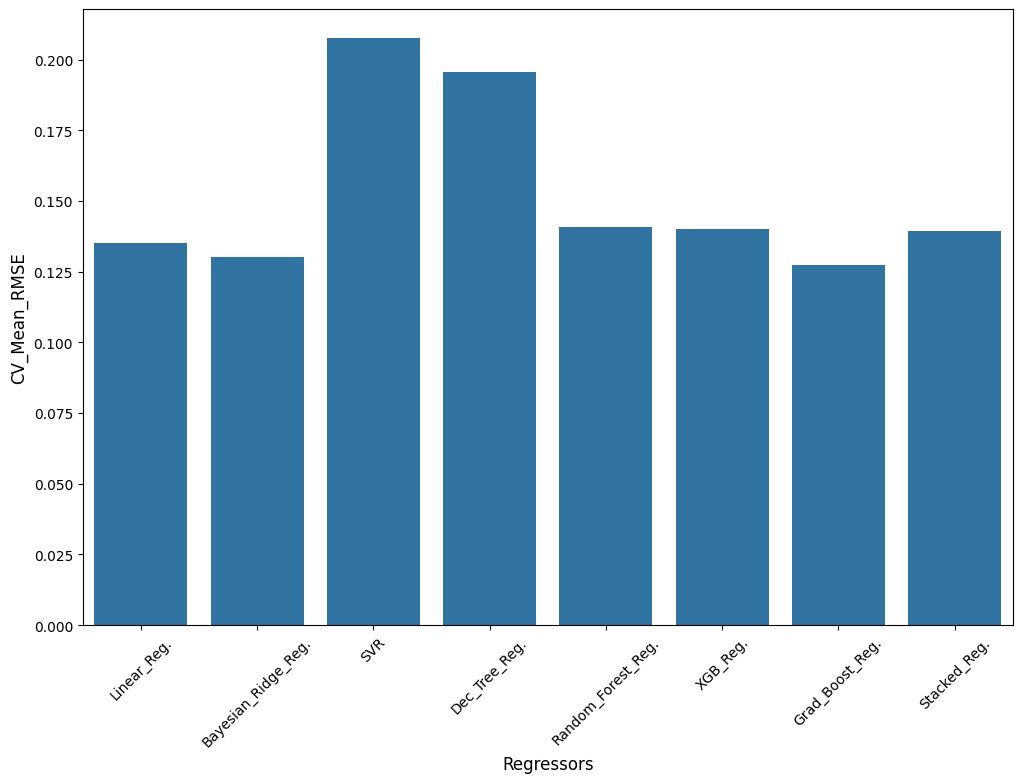

In [332]:
# PLot final cv score
plt.figure(figsize = (12,8))
sns.barplot(x =final_cv_score['Regressors'],y =final_cv_score['RMSE_mean'])
plt.xlabel('Regressors', fontsize = 12)
plt.ylabel('CV_Mean_RMSE', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

From this, it seems that the best-performing models in terms of minimizing RMSE are Bayesian Ridge Regression, Linear Regression, and Gradient Boosting Regressor, as they achieved lower cross-validated RMSE scores compared to other models.

However, after evaluating the performance of all models, we have decided to proceed with XGBoost. Although it was not the top performer in terms of RMSE, this is a learning exercise, and our primary goal is to gain a deeper understanding of XGBoost due to its widespread use and flexibility. XGBoost is highly efficient and often outperforms other models when hyperparameters are carefully tuned, making it an excellent candidate for further exploration.

With this in mind, we will now split the training dataset into training and validation sets and begin fitting the models. 

In [333]:
# Train-Test split the data

X_train,X_val,y_train,y_val = train_test_split(X_train,target_col,test_size = 0.1,random_state=42)

In [334]:
# Fit the model on the training data and evaluate on the validation set
xgb_model = xgb.fit(X_train, y_train, 
                    eval_set=[(X_val, y_val)], 
                    verbose=False)

In [335]:
# Predictions
y_pred = xgb_model.predict(X_val)

In [336]:
# Score
xgb_score = rmse(y_val, y_pred)
xgb_score

0.35219847309190777

Once we have trained the model, we will proceed to explore the importance of each feature in contributing to the model's predictions. Understanding feature importance allows us to identify which variables have the most significant impact on the model's performance, helping us to interpret the model and potentially refine it.

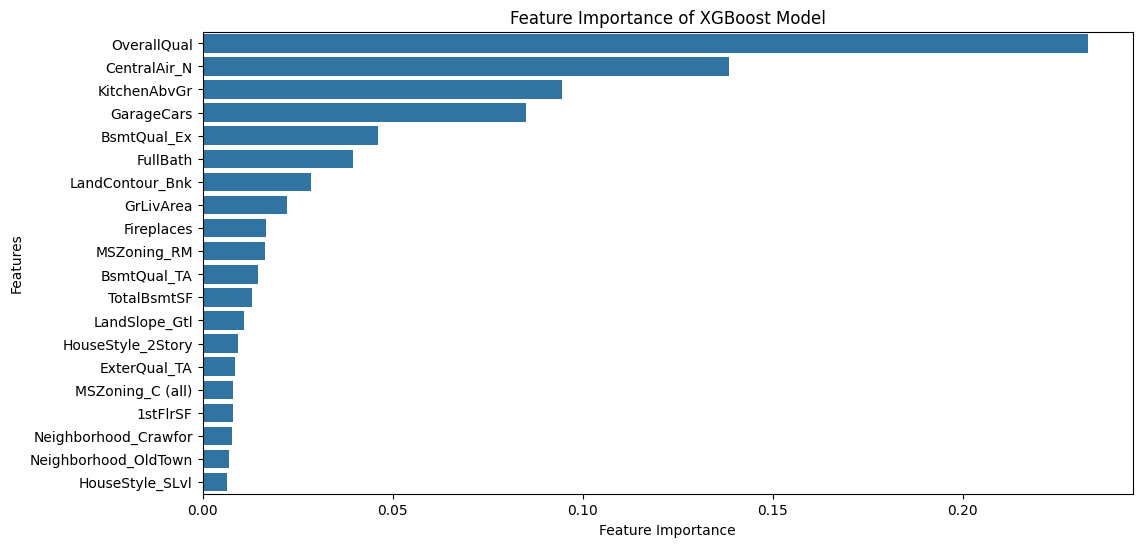

In [337]:
# Get feature importance
feat_imp = xgb_model.feature_importances_

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,  # Assuming X_train is a DataFrame
    'Importance': feat_imp
})

# Sort the DataFrame by importance
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Select the top 5 features
top_features = feat_imp_df.head(20)

# Plotting feature importance
plt.figure(figsize=(12, 6))
sns.barplot(y=top_features['Feature'], x=top_features['Importance'],  orient='h')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of XGBoost Model')
plt.show()

We can see that several features we initially identified as important, such as **OverallQual**, **GarageCars**, and **GrLivArea**, have indeed proven to be highly influential in the XGBoost model, confirming their relevance in predicting the target variable.

In particular:

- **OverallQual** stands out as by far the most important feature, with a significantly higher importance score than any other variable. This suggests that the overall quality of the property has the largest impact on the model's predictions, likely because it encapsulates a range of factors that affect the property's value.

- **CentralAir_N** and **KitchenAbvGr** are also ranked highly, indicating that whether or not the property has central air conditioning and the quality of the kitchen space play key roles in the model's predictions.

- **GarageCars** and **BsmtQual_Ex** (the number of cars that can fit in the garage and the excellent quality of the basement, respectively) are both critical features, suggesting that parking and basement quality significantly contribute to the value of a home.

- **GrLivArea** (the above-ground living area) is another important factor, as expected, since larger living spaces often increase the overall property value.


Now, lets procced with hyperparameter tuning. To do so, we will be implementing Randomized Search CV.

- Randomized Search, as opposed to a grid search, allows for a more efficient exploration of the hyperparameter space. Grid search can become computationally expensive, especially when the parameter grid is large. Randomized Search samples a fixed number of parameter combinations, which often leads to finding good parameter settings with fewer computational resources.

- It randomly samples from the specified parameter distributions, helping to cover more ground in the hyperparameter space. This can be particularly advantageous in high-dimensional spaces where exhaustive search (like grid search) would be infeasible.

- The parameters we will be tuning are: the number of trees (n_estimators), the learning rate, the max depth of each tree and the regularization.
    - n_estimators: More estimators generally lead to better model performance as the model can learn more complex patterns in the data. However, increasing n_estimators also increases the risk of overfitting, particularly if the learning rate is not adequately tuned.
    - learning_rate: Step size at each iteration while moving toward a minimum of the loss function. A smaller learning rate makes the model more robust and can help achieve better performance, but it requires more boosting rounds to converge. It controls how much the weights of the trees are adjusted during training.
    - max_depth: Deeper trees can capture more complex patterns in the data, but they are also more prone to overfitting, especially with noisy data. Finding an optimal depth helps to maximize the model's predictive capability while maintaining generalization.
    - reg_lambda: This parameter applies L2 regularization to the weights, which can help prevent overfitting. Regularization penalizes large weights in the model, promoting simpler models that can generalize better to unseen data.

In [273]:
# Define the parameter grid
param_dist = {
    'n_estimators': [1000, 6000],           # Number of boosting rounds (trees)
    'learning_rate': [0.05, 0.005, 0.0005], # Step-size
    'max_depth': [4, 6, 10],                # Max depth of each tree
    'reg_lambda': [1, 3, 5, 9]              # L2 regularization
}

# Initialize the XGBRegressor
xgb_model = xgb

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_dist,
                                   n_iter=10,                         # 10 different parameter combinations
                                   scoring='neg_mean_squared_error',  # Use an appropriate scoring metric
                                   cv=3,                              # 3-fold cross-validation
                                   verbose=1,                         # Some Verbosity
                                   random_state=42,                   # Seed for reproducibility
                                   n_jobs=-1)                         # Use all available cores

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Best model
final_model = random_search.best_estimator_

# Best score achieved during the search
best_score = random_search.best_score_
print("Best cross-validation score: ", best_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'reg_lambda': 1, 'n_estimators': 6000, 'max_depth': 4, 'learning_rate': 0.05}
Best cross-validation score:  -0.01913078851973798


In [338]:
import xgboost as xgb

# Final Fine-Tuned XGB
params= {
    'n_estimators': 6000,      
    'learning_rate': 0.05,
    'max_depth': 4,
    'reg_lambda': 1          
}

xgb_final = xgb.XGBRegressor(**params)

# Fit the Model
xgb_model_final = xgb_final.fit(X_train, y_train, 
                    eval_set=[(X_val, y_val)], 
                    verbose=False)

# Predict on validation dataset
xgbf_pred = xgb_model_final.predict(X_val)

# Compute RMSE score
xgbf_score = rmse(y_val, xgbf_pred)

In [339]:
xgbf_score

0.3249983191134193

In [340]:
# Check if we messed dataset up somewhere by computing mean average ground truth price
np.expm1(target_col).mean()

180921.19589041095

In [341]:
# Compute final predictions on Kaggle's test dataset
test_pred = xgb_model_final.predict(X_test)
test_pred = np.expm1(test_pred)

# Check if we messed up, as above
test_pred.mean()

177528.52

In [342]:
# Create Kaggle's submission DF
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = test_pred
sub.head()

,Id,SalePrice
0,1461,126265.976562
1,1462,155528.812500
2,1463,188635.343750
3,1464,192440.625000
4,1465,180052.343750


In [279]:
# End of the notebook
sub.to_csv('submission.csv',index=False)